<h2 style="font-family:'Century Gothic', 'Tahoma';">Analisis de precios pre-post Elecciones PASO</h2>
<br>

<h3 style="font-family:'Century Gothic', 'Tahoma';"> Objetivos y estrategias </h3>
<p style="font-family: 'Century Gothic', 'Times New Roman';">
A través del proyecto buscamos analizar el impacto (si es que existe) del contexto electoral sobre un grupo de productos elegidos dentro de la plataforma de compra 'MercadoLibre'.
<br>
Se eligieron productos de diferentes categorias,destacando:
</p>
<ul style="font-family: 'Century Gothic', 'Times New Roman';">
    <li>Alimentos y Bebidas</li>
    <li>Electronica</li>
    <li>Electrodomesticos</li>
    <li>Alimentos para mascotas</li>
</ul>
<br>

<p style="font-family: 'Century Gothic', 'Times New Roman';">
La informacion de los productos fue obtenida a través de la API de Mercadolibre. En paralelo se obtuvieron los valores diarios de los distintos tipos de dolar a través de <a href="https://dolarapi.com/docs">Dolar API</a>. Finalmente todos los datos fueron insertados en PostgreSQL. 
<br><br>
Para ello se creó un esquema de Datawarehouse separado en 3 'Schema': Source, Staging y Core. El objetivo fue insertar la información en pocas tablas para luego implementar un sistema 'dimensional' al estilo Kimball como repositorio definitivo.
</p>
<br>
<p style="font-family: 'Century Gothic', 'Times New Roman';">
La orquestación de tareas y su posterior automatización fue llevada a cabo con <a href="https://www.hitachivantara.com/en-us/products/pentaho-platform/data-integration-analytics.html"> Pentaho Data Integration </a>.
</p>
<br><br>
<p style="font-family: 'Century Gothic', 'Times New Roman';">
Finalmente, para el análisis hemos utilizado una combinación de SQL y Python
</p>

In [33]:
import pandas as pd
from postgrecon import sqlconn
import matplotlib.pyplot as plt
import seaborn as sns

#Abrimos conexion a PostgreSQL
conexion = sqlconn()
cursor = conexion.cursor()

Conexion establecida correctamente


<p style="font-family: 'Century Gothic', 'Times New Roman';"> 
Comenzamos importando las librerias necesarias para crear y trabajar el set de datos. A continuación creamos la conexion a PosgreSQL.</p>
<br>

<p style="font-family: 'Century Gothic', 'Times New Roman';"> Veamos primero que paso con el dólar para luego pensar si tuvo alguna influencia o no en el precio de los productos de nuestra 'canasta mercadolibre'</p>

In [34]:
cursor.execute("SELECT * FROM core.pf_dolar")
cols_dolar = [e[0] for e in cursor.description]
res_dolar= cursor.fetchall()
df_dolar = pd.DataFrame(data=res_dolar,columns=cols_dolar)
df_dolar['d_fecha'] = pd.to_datetime(df_dolar['d_fecha'])
df_dolar

,d_id,d_oficial,d_blue,d_bolsa,d_ccl,d_fecha
0,3,297.20,600.00,527.91,561.93,2023-08-09
1,4,298.16,602.00,530.31,570.51,2023-08-10
2,5,299.73,605.00,541.29,576.70,2023-08-11
3,6,299.73,605.00,541.29,576.70,2023-08-12
4,7,300.34,605.00,541.29,576.70,2023-08-13
5,8,360.64,685.00,637.36,679.37,2023-08-14
6,9,366.29,730.00,667.17,704.35,2023-08-15
7,10,367.58,780.00,651.41,732.25,2023-08-16
8,11,367.54,760.00,662.04,707.07,2023-08-17
9,12,367.68,720.00,657.48,698.80,2023-08-18


<p style="font-family: 'Century Gothic', 'Times New Roman';">Para mayor claridad, lo presentamos en un gráfico</p>

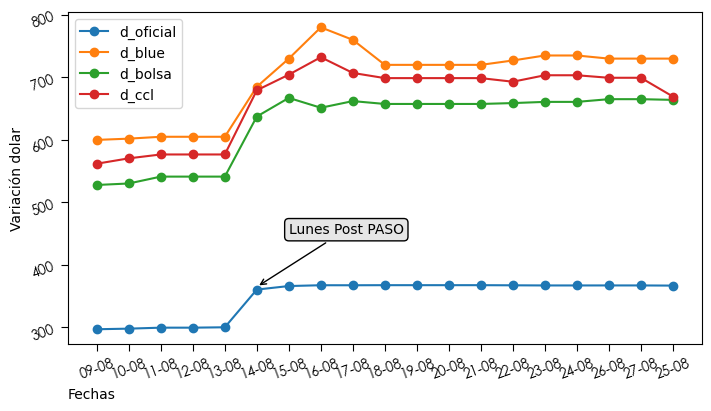

In [3]:
#Preparamos y personalizamos el gráfico
tipos_dolar =  cols_dolar[1:5]
df_dolar['d_fecha_corta'] = df_dolar['d_fecha'].dt.strftime("%d-%m")


plt.figure(layout='constrained',figsize=(7,4))
# plt.axes().set_facecolor('grey')

plt.tick_params('both',size=5)
plt.xlabel(xlabel='Fechas',loc='left')
plt.ylabel(ylabel='Variación dolar',loc='center')
plt.xticks(size=10,rotation=20,fontname='Century Gothic')
plt.yticks(size=10,rotation=20,fontname='Century Gothic')


for cols in tipos_dolar:
    x = df_dolar['d_fecha_corta']
    y = df_dolar[cols]
    plt.plot(x,y,marker='o',label=cols)

# Agregamos anotaciones finales
bbox = dict(boxstyle ="round", fc ="0.9")
arrow = dict(facecolor ='grey',arrowstyle="->")
plt.annotate("Lunes Post PASO", xy=('14-08','365'),xytext=('15-08','450'),bbox=bbox,arrowprops = arrow)

plt.legend()
plt.show()

<p style="font-family: 'Century Gothic', 'Times New Roman';">
Ahora vamos a cargar el set principal a un DataFrame de Pandas y evaluar las formas de análisis.
</p>

<p style="font-family: 'Century Gothic', 'Times New Roman';">
Hacemos una mirada inicial al DataFrame tal cual sale del origen de datos
</p>

In [5]:
#Cargamos
df = pd.read_csv('data-precios.csv')
# Miramos estructura de datos
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646 entries, 0 to 645
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fact_date            646 non-null    object 
 1   fact_mla             646 non-null    object 
 2   prd_title            646 non-null    object 
 3   prd_category         646 non-null    object 
 4   fact_price           646 non-null    float64
 5   fact_doficial_price  646 non-null    float64
 6   fact_dblue_price     646 non-null    float64
dtypes: float64(3), object(4)
memory usage: 35.5+ KB


In [6]:
# Mustra de la parte superior
df.head(5)

,fact_date,fact_mla,prd_title,prd_category,fact_price,fact_doficial_price,fact_dblue_price
0,2023-08-09,MLA14541957,Pava Eléctrica Peabody Pe-k1708 Plateada 220v ...,Electrodomésticos y Aires Ac.,15399.0,51.81,25.67
1,2023-08-10,MLA14541957,Pava Eléctrica Peabody Pe-k1708 Plateada 220v ...,Electrodomésticos y Aires Ac.,14599.0,48.96,24.25
2,2023-08-11,MLA14541957,Pava Eléctrica Peabody Pe-k1708 Plateada 220v ...,Electrodomésticos y Aires Ac.,14999.0,50.04,24.79
3,2023-08-12,MLA14541957,Pava Eléctrica Peabody Pe-k1708 Plateada 220v ...,Electrodomésticos y Aires Ac.,14999.0,50.04,24.79
4,2023-08-13,MLA14541957,Pava Eléctrica Peabody Pe-k1708 Plateada 220v ...,Electrodomésticos y Aires Ac.,14999.0,49.94,24.79


<p style="font-family: 'Century Gothic', 'Times New Roman';">
TEMA 1: CAMBIO DE PRECIOS
<br>
<br>
Analizamos de manera general cual fue la variacion de precios entre fecha inicial y final.
</p>

In [7]:
def variacion(x):
    primer_precio = x.iloc[0]
    ultimo_precio = x.iloc[-1]
    var = ((ultimo_precio - primer_precio) / primer_precio) * 100
    return var

variacion_final = df.groupby(['fact_mla','prd_title','prd_category']).agg(variacion=('fact_price',variacion)).reset_index().sort_values(by='variacion', ascending=False)


In [414]:
#Columna variacion diaria
# df['fact_date'] = pd.to_datetime(df['fact_date'])
# df['Variacion'] = df['fact_price'].diff() / df['fact_price'] * 100



<p style="font-family: 'Century Gothic', 'Times New Roman';">Top 5 productos con MAYOR variacion % de precio </p>

In [8]:
variacion_final.head(5)

,fact_mla,prd_title,prd_category,variacion
22,MLA20081216,Dulce De Leche Clásico La Serenísima 400 Gr,Alimentos y Bebidas,144.141252
4,MLA16106394,Pava Eléctrica Westinghouse Wh-pe0192m Acero 2...,Electrodomésticos y Aires Ac.,80.558303
13,MLA19785621,Detergente Cif Bioactive Limon Doypack X 450 Ml,"Hogar, Muebles y Jardín",80.000000
2,MLA16009102,Papel Higiénico Higienol Max Simple 80 M Pack ...,"Hogar, Muebles y Jardín",62.534149
24,MLA20719496,Jabon En Barra Lux Botanicals Jazmin Cremoso 3...,Belleza y Cuidado Personal,58.635704


<p style="font-family: 'Century Gothic', 'Times New Roman';">Top 5 productos con MENOR variación de precios</p>

In [9]:
variacion_final.tail(5)

,fact_mla,prd_title,prd_category,variacion
17,MLA19944508,La Virginia Cafe Tostado Grano Puro Aroma X 50...,Alimentos y Bebidas,5.003088
30,MLA24208897,Shampoo Dove Regeneración Extrema X 400 Ml,Belleza y Cuidado Personal,1.010401
27,MLA21024384,Samsung Galaxy A04 128 Gb Negro 4 Gb Ram,Celulares y Teléfonos,0.535357
9,MLA19543952,Jabon Tocador Manos Familiar Palmolive Almendr...,Belleza y Cuidado Personal,0.000000
3,MLA16010049,Aceite De Girasol Natura Botellasin Tacc 1.5 L,Alimentos y Bebidas,-16.864608


<p style="font-family: 'Century Gothic', 'Times New Roman';">Ahora que tenemos una idea general, analizamos cuales fueron las variaciones Maximas, Minimas y Promedio, POR CATEGORIA a nivel DIARIO.</p>

In [10]:
variacion_categoria = variacion_final[['prd_category','variacion']].groupby('prd_category').agg({'variacion': ['max','min','mean']}).reset_index()
variacion_categoria.rename(columns={'mean': 'Promedio','max': 'Máxima','min': 'Mínima'},inplace=True)
variacion_categoria


prd_category   variacion                      
                                      Máxima     Mínima   Promedio
0            Alimentos y Bebidas  144.141252 -16.864608  28.191347
1            Animales y Mascotas   29.925910  28.843246  29.384578
2                          Bebés   36.390576  36.390576  36.390576
3     Belleza y Cuidado Personal   58.635704   0.000000  17.386172
4          Celulares y Teléfonos   38.432126   0.535357  19.483742
5                    Computación   42.361699  28.466684  35.414192
6             Deportes y Fitness   19.596751  19.596751  19.596751
7  Electrodomésticos y Aires Ac.   80.558303  21.462433  39.293939
8     Electrónica, Audio y Video   33.154602  33.154602  33.154602
9        Hogar, Muebles y Jardín   80.000000  19.018776  53.431659

<p style="font-family: 'Century Gothic', 'Times New Roman';">TEMA 2: Volatilidad de precios<br>

Si observamos mas en detalle, los dias posteriores a las elecciones el caos de precios fue mayor debido a la incertidumbre, aunque luego de algunos dias los mismos se acomodaron a la baja.<br>

¿Cuantas veces se 'remarcaron los precios' durante el período en análisis?</p>

In [11]:
#Cuantas veces se remarcaron los precios?
df['fact_date'] = pd.to_datetime(df['fact_date'])
df['variacion_diaria'] = df['fact_price'].diff() / df['fact_price'] * 100
df[['prd_title','variacion_diaria']][df['variacion_diaria'] != 0].groupby('prd_title').count().sort_values('variacion_diaria',ascending=False)


,variacion_diaria
prd_title,
Monitor Gamer Samsung F22t35 Led 22 Dark Blue Gray 100v/240v,14
Licuadora De Vaso Philco Li8445pp 400w 2 Vel + Pulso,13
Celular Motorola Moto E13 64gb 2gb Ram Azul Turquesa,13
Monitor Gamer Samsung F24t35 Led 24 Azul Y Gris Oscuro 100v/240v,13
Samsung Galaxy A04 128 Gb Negro 4 Gb Ram,12
Yerba Mate Canarias Sabor Tradicional 1kg,11
Pava Eléctrica Westinghouse Wh-pe0192m Acero 220v 1.8l,11
Papel Higiénico Higienol Max Simple 80 M Pack De 4,11
Licuadora Smartlife Sl-bl1008 1.5 L Blanca Con Jarra De Vidrio 220v - 240v,11


<p style="font-family: 'Century Gothic', 'Times New Roman';">Bien. Veamos ahora como fue la variacion diaria por categoria para analizar la disperión o no de estos aumentos y comprobar si es cierto que hubo fluctuaciones hasta encontrar un equilibrio.<br>
La decisión fue sumar lo que vale 'la suma de $ de cada categoria" y analizar su variación durante el período. Para que los datos fuesen comparables entre categorías se utilizó un escalador/normalizador</p>

In [12]:
#Importamos las librerias necesarias
from sklearn.preprocessing import StandardScaler
from matplotlib import style
import plotly.express as px
import plotly.offline as pyo

In [14]:
#Achicamos el DataFrame a lo necesario. Aun estamos con una vista a nivel articulo
suma_categorias = df[['fact_date','prd_title','prd_category','fact_price']]
suma_categorias


,fact_date,prd_title,prd_category,fact_price
0,2023-08-09,Pava Eléctrica Peabody Pe-k1708 Plateada 220v ...,Electrodomésticos y Aires Ac.,15399.0
1,2023-08-10,Pava Eléctrica Peabody Pe-k1708 Plateada 220v ...,Electrodomésticos y Aires Ac.,14599.0
2,2023-08-11,Pava Eléctrica Peabody Pe-k1708 Plateada 220v ...,Electrodomésticos y Aires Ac.,14999.0
3,2023-08-12,Pava Eléctrica Peabody Pe-k1708 Plateada 220v ...,Electrodomésticos y Aires Ac.,14999.0
4,2023-08-13,Pava Eléctrica Peabody Pe-k1708 Plateada 220v ...,Electrodomésticos y Aires Ac.,14999.0
...,...,...,...,...
641,2023-08-23,Alimento Dog Selection Criadores Para Perro Ad...,Animales y Mascotas,12676.0
642,2023-08-24,Alimento Dog Selection Criadores Para Perro Ad...,Animales y Mascotas,12676.0
643,2023-08-25,Alimento Dog Selection Criadores Para Perro Ad...,Animales y Mascotas,12676.0
644,2023-08-26,Alimento Dog Selection Criadores Para Perro Ad...,Animales y Mascotas,12100.0


In [16]:

sum_categorias = suma_categorias.groupby(['fact_date', 'prd_category'])['fact_price'].sum().reset_index()
sum_categorias.head(5)

,fact_date,prd_category,fact_price
0,2023-08-09,Alimentos y Bebidas,12377.99
1,2023-08-09,Animales y Mascotas,25185.00
2,2023-08-09,Bebés,6749.00
3,2023-08-09,Belleza y Cuidado Personal,4920.71
4,2023-08-09,Celulares y Teléfonos,130572.00


In [17]:
from sklearn.preprocessing import StandardScaler

# Agrupa los datos por 'prd_category'
grupos = sum_categorias.groupby('prd_category')

scaler = StandardScaler()
scaled_df = pd.DataFrame()

for categoria, grupo in grupos:
    # Ajusta el escalador en la columna de precios del grupo
    scaler.fit(grupo[['fact_price']])
    
    grupo['fact_price_scaled'] = scaler.transform(grupo[['fact_price']])
    
    scaled_df = pd.concat([scaled_df, grupo])

# Muestra el DataFrame final con los datos escalados

scaled_df

,fact_date,prd_category,fact_price,fact_price_scaled
0,2023-08-09,Alimentos y Bebidas,12377.99,-1.915711
10,2023-08-10,Alimentos y Bebidas,12403.00,-1.893570
20,2023-08-11,Alimentos y Bebidas,13226.00,-1.165007
30,2023-08-12,Alimentos y Bebidas,13117.00,-1.261499
40,2023-08-13,Alimentos y Bebidas,13437.00,-0.978218
...,...,...,...,...
149,2023-08-23,"Hogar, Muebles y Jardín",7414.98,0.810657
159,2023-08-24,"Hogar, Muebles y Jardín",7414.98,0.810657
169,2023-08-25,"Hogar, Muebles y Jardín",7414.98,0.810657
179,2023-08-26,"Hogar, Muebles y Jardín",7299.00,0.698539


In [18]:
scaled_df.reset_index(drop=True,inplace=True)
scaled_df

,fact_date,prd_category,fact_price,fact_price_scaled
0,2023-08-09,Alimentos y Bebidas,12377.99,-1.915711
1,2023-08-10,Alimentos y Bebidas,12403.00,-1.893570
2,2023-08-11,Alimentos y Bebidas,13226.00,-1.165007
3,2023-08-12,Alimentos y Bebidas,13117.00,-1.261499
4,2023-08-13,Alimentos y Bebidas,13437.00,-0.978218
...,...,...,...,...
185,2023-08-23,"Hogar, Muebles y Jardín",7414.98,0.810657
186,2023-08-24,"Hogar, Muebles y Jardín",7414.98,0.810657
187,2023-08-25,"Hogar, Muebles y Jardín",7414.98,0.810657
188,2023-08-26,"Hogar, Muebles y Jardín",7299.00,0.698539


In [19]:
# Grafico en Plotly
fig = px.line(scaled_df, x='fact_date', y='fact_price_scaled', color='prd_category',
              title='Evolución de Precios Escalados por Categoría',markers='o')

# Mostrar el gráfico interactivo
pyo.plot(fig)

'temp-plot.html'

<p style="font-family: 'Century Gothic', 'Times New Roman';">Así como lo pensamos antes, se aprecia un periodo de 'Incertidumbre' entre el 13-08 y 17-08 hasta lograr un equilibrio pasado el 20-8 <br><br>

Analizamos ahora CORRELACION,por ejemplo, entre el dolar y los Alimentos y Bebidas</p>

In [20]:
sum_alimentos = sum_categorias[sum_categorias['prd_category'] == 'Alimentos y Bebidas']
sum_alimentos.reset_index(drop=True, inplace=True)
sum_alimentos



,fact_date,prd_category,fact_price
0,2023-08-09,Alimentos y Bebidas,12377.99
1,2023-08-10,Alimentos y Bebidas,12403.00
2,2023-08-11,Alimentos y Bebidas,13226.00
3,2023-08-12,Alimentos y Bebidas,13117.00
4,2023-08-13,Alimentos y Bebidas,13437.00
5,2023-08-14,Alimentos y Bebidas,14507.00
6,2023-08-15,Alimentos y Bebidas,15084.00
7,2023-08-16,Alimentos y Bebidas,16451.00
8,2023-08-17,Alimentos y Bebidas,16147.56
9,2023-08-18,Alimentos y Bebidas,15404.00


In [21]:
# Utilizamos el dia 1 como ancla de variacion

def calcular_variacion(columna):
    primera_fila = columna.iloc[0]
    if primera_fila == 0:
        return 0  # Evita la división por cero
    return (columna - primera_fila) / primera_fila * 100



In [22]:
sum_alimentos['var_acumulada']= sum_alimentos['fact_price'].transform(calcular_variacion)
df_dolar['var_acumulada_blue']= df_dolar['d_blue'].transform(calcular_variacion)
df_dolar['var_acumulada_oficial']= df_dolar['d_oficial'].transform(calcular_variacion)
sum_alimentos['var_acumulada_blue'] = df_dolar['var_acumulada_blue']
sum_alimentos['var_acumulada_oficial'] = df_dolar['var_acumulada_oficial']



C:\Users\JP\AppData\Local\Temp\ipykernel_9052\1348205328.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JP\AppData\Local\Temp\ipykernel_9052\1348205328.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\JP\AppData\Local\Temp\ipykernel_9052\1348205328.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

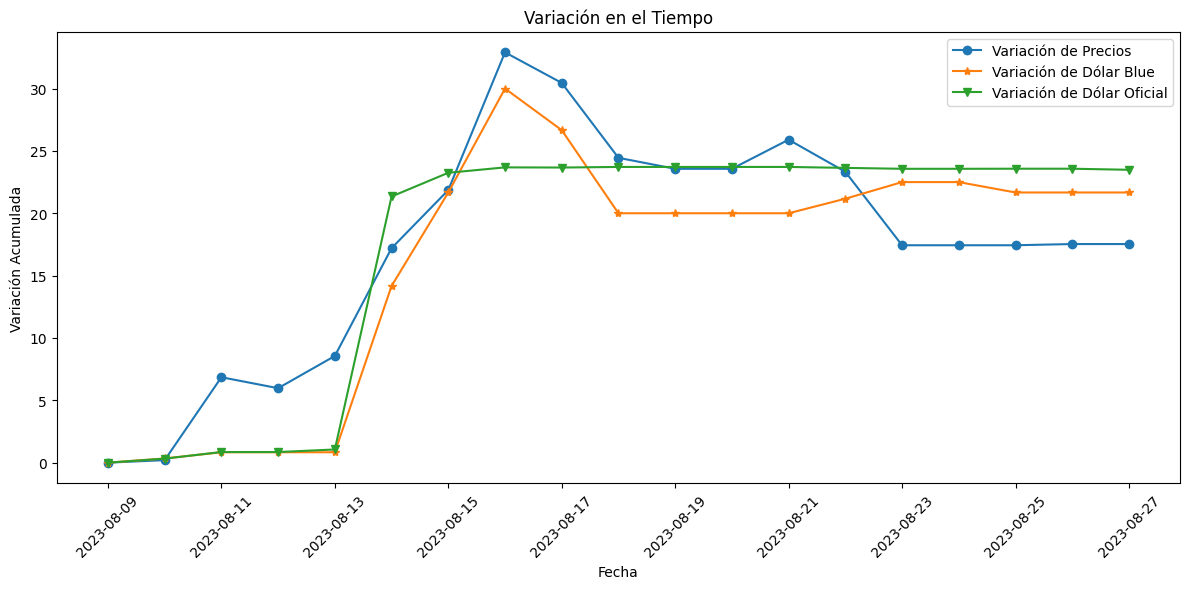

In [25]:

# Preparamos una gráfica

fechas = sum_alimentos['fact_date']
variacion_precios = sum_alimentos['var_acumulada']
variacion_dolar_blue = sum_alimentos['var_acumulada_blue']
variacion_dolar_oficial = sum_alimentos['var_acumulada_oficial']

plt.figure(figsize=(12, 6))  # Tamaño del gráfico
plt.plot(fechas, variacion_precios, label='Variación de Precios', marker='o')
plt.plot(fechas, variacion_dolar_blue, label='Variación de Dólar Blue', marker='*')
plt.plot(fechas, variacion_dolar_oficial, label='Variación de Dólar Oficial', marker='v')

# Personalizar el gráfico
plt.title('Variación en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Variación Acumulada')
plt.legend()  # Mostrar leyenda

# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


<p style="font-family: 'Century Gothic', 'Times New Roman';">

Como última gráfica, vamos a incluir un 'pack' de articulos de tecnología para evaluar si la suba de precios tuvo mayor o menor correlación con los aumentos de las paridades del dolar

</p>

In [26]:
cat_tecnologia = ['Computación','Electrodomésticos y Aires Ac.','Celulares y Teléfonos']
df_tecno = sum_categorias[sum_categorias['prd_category'].isin(cat_tecnologia)]
replace = {'Celulares y Teléfonos': 'tecnologia', 'Electrodomésticos y Aires Ac.': 'tecnologia', 'Computación': 'tecnologia' }

df_tecno['prd_category'] = df_tecno['prd_category'].replace(replace)
df_tecno


C:\Users\JP\AppData\Local\Temp\ipykernel_9052\1001297814.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,fact_date,prd_category,fact_price
4,2023-08-09,tecnologia,130572.00
5,2023-08-09,tecnologia,135828.00
7,2023-08-09,tecnologia,55996.00
14,2023-08-10,tecnologia,130422.00
15,2023-08-10,tecnologia,146799.00
17,2023-08-10,tecnologia,55681.95
24,2023-08-11,tecnologia,128948.00
25,2023-08-11,tecnologia,136038.20
27,2023-08-11,tecnologia,56502.95
34,2023-08-12,tecnologia,130448.00


In [27]:
# Agrupar por 'fact_date' y sumar los valores
df_agrupado = df_tecno.groupby('fact_date')['fact_price'].sum().reset_index()

#Buscamos esa variacion de los productos de tecnologia para llevarla al set ya armado
#Con los diferentes tipos de dolar
df_agrupado.reset_index(drop=True, inplace=True)
df_agrupado['variacion_tecnologia'] = df_agrupado['fact_price'].transform(calcular_variacion)
df_agrupado
sum_alimentos['variacion_tecnologia'] = df_agrupado['variacion_tecnologia']


C:\Users\JP\AppData\Local\Temp\ipykernel_9052\475253343.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



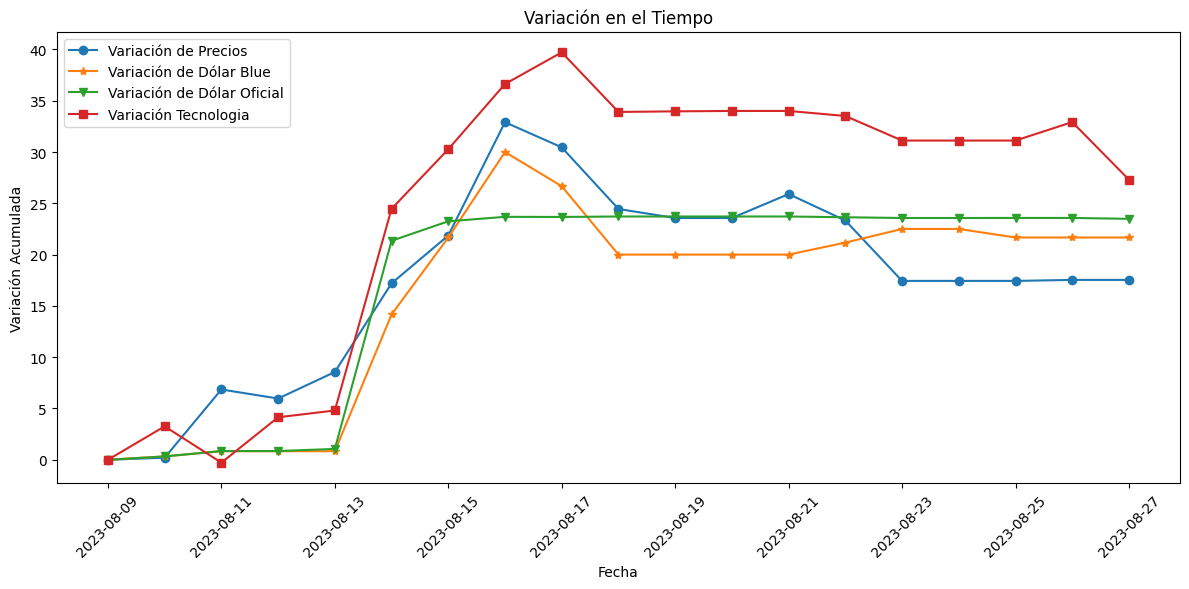

In [29]:

# Creamos grafico
fechas = sum_alimentos['fact_date']
variacion_precios = sum_alimentos['var_acumulada']
variacion_tecno = sum_alimentos['variacion_tecnologia']
variacion_dolar_blue = sum_alimentos['var_acumulada_blue']
variacion_dolar_oficial = sum_alimentos['var_acumulada_oficial']


plt.figure(figsize=(12, 6))  # Tamaño del gráfico
plt.plot(fechas, variacion_precios, label='Variación de Precios', marker='o')
plt.plot(fechas, variacion_dolar_blue, label='Variación de Dólar Blue', marker='*')
plt.plot(fechas, variacion_dolar_oficial, label='Variación de Dólar Oficial', marker='v')
plt.plot(fechas, variacion_tecno, label='Variación Tecnologia', marker='s')

# Personalizar el gráfico
plt.title('Variación en el Tiempo')
plt.xlabel('Fecha')
plt.ylabel('Variación Acumulada')
plt.legend()  # Mostrar leyenda

# Rotar las etiquetas del eje x para una mejor visualización
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

<p style="font-family: 'Century Gothic', 'Times New Roman';">

Para finalizar analicemos todas estas variaciones que tenemos en una matriz de correlaciones.

</p>

In [30]:
df_simplified = sum_alimentos[['fact_date', 'var_acumulada', 'var_acumulada_blue', 'var_acumulada_oficial', 'variacion_tecnologia']]
df_simplified.corr()

,fact_date,var_acumulada,var_acumulada_blue,var_acumulada_oficial,variacion_tecnologia
fact_date,1.000000,0.520952,0.735025,0.778882,0.727972
var_acumulada,0.520952,1.000000,0.911273,0.873358,0.927452
var_acumulada_blue,0.735025,0.911273,1.000000,0.961679,0.973038
var_acumulada_oficial,0.778882,0.873358,0.961679,1.000000,0.978130
variacion_tecnologia,0.727972,0.927452,0.973038,0.978130,1.000000


<h2 style="font-family:'Century Gothic', 'Tahoma';">Conclusiones</h2>

<p style="font-family: 'Century Gothic', 'Times New Roman';">
El periodo pre electoral ya venia anticipando con leves subas de precios durante el fin de semana propio de las elecciones 'anticipandose' a un escenario de incertidumbre.<br>

Algunas claves:</p>


<ul style="font-family: 'Century Gothic', 'Times New Roman';">
    <li>El aumento esperado de las tasas de cambio fue el disparador de subas de precios que de promedio fueron de un 30%, en tan solo una semana. Los primeros 4 días post</li>
    <li>Algunas categorías, como los productos de tecnología, han quedado por encima del aumento de la tasa de cambios, reflejando y anticipando que el aumento del dolar puede ser mayor</li>
    <li>El hecho de que haya tanta remarciación diaria, indica que el comerciante 'no sabe que precio poner' y va haciendo 'micro-ajustes' en función de la demanda.</li>
    <li>Hay productos claves que fueron pausados por el sitio MercadoLibre al martes posterior de las elecciones (ejemplo: botella de agua Nestle 1.5l)</li>
    <li>No todos los aumentos por categoria fueron parejos y sorprenden rubros que uno imagina no dolarizados como el alimento para mascotas con subas por encima de la media.</li>
    <li>Luego de una batería de medidas gubernamentales, los productos de grandes marcas de alimentos buscaron un equilibrio y quedaron por debajo de la suba del denominado 'dolar blue'</li>
    <li>Se demuestra, tristemente, que la correlación entre 'dolar blue' y los productos es mas fuerte que con el dolar oficial. Esto quiere decir que a pesar que los productos de tecnología elegidos son todos fabricados en el país, si sube el dolar paralelo, es probable que suban</li>
</ul>
<br><br><br>
<p style="font-family: 'Century Gothic', 'Times New Roman';">
Espero que les haya gustado. Dejamos la puerta abierta a mas análisis...
</p>


